[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alikn/intro_to_ai/blob/master/linear_regression.ipynb)

This notebook is forked from [mjghorbany](https://github.com/mjghorbany)'s [Machine Learning Deep Dive](https://github.com/mjghorbany/Machine-Learning-DeepDive) Github repo.

# Linear Regression

#### Learning Objectives
- Define data modeling and simple linear regression.
- Build a linear regression model 
- Understand and identify multicollinearity in a multiple regression.

<a id="introduce-the-bikeshare-dataset"></a>
## Bikeshare Data Set
---

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

# Import Libraries

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data

In [71]:
# Read the data and set the datetime as the index.
url = 'https://alik-courses.web.app/intro-to-ai/linear_regression/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

Notice that we used `index_col` to set an index or primary key for our data. In this case, the index of each row will be set to the value of its `datetime` field.

We also ask Pandas to parse dates (if `parse_dates=True`, for the index only). So, rather than reading in a string, Pandas converts the index string to a `datetime` object.

In [72]:
# Preview the first five rows of the DataFrame.
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### How many features are there?

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1=winter, 2=spring, 3=summer, 4=fall |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| See Below|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|count| number of total rentals|

> _Details on Weather Variable_

> **1**: Clear, Few clouds, Partly cloudy, Partly cloudy

> **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

> **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

> **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

"count" is a method in Pandas (and a very non-specific name), so it's best to name that column something else

In general, you may want to rename columns if it is not obvious what might be stored in them. Although we will only rename the target column here, a few examples might be to rename:

| old name | new name |
| ---    | --- |
| temp | temp_celcius
| windspeed | windspeed_knots
| casual | num_casual_users
| registered | num_registered_users
| season | season_num
| holiday | is_holiday
| workingday | is_workingday
| humidity | humidity_percent

Without having to check, these new names make it obvious what is stored in each column. The downside is slightly longer column names, which could affect table readability in Jupyter. It would be ideal to use very specific names in CSV files to assist others reading them. In your own code, use whatever makes sense for your work -- if you are viewing lots of Pandas tables, you may want to use shorter names. However, readable specific names are preferred in Python code since it prevents mistakes.

In [73]:
# Use the .rename() method to rename count to total
bikes.rename(columns={'count':'total_rentals','casual':'non_registered_users'}, inplace=True)
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<a id="visualizing-the-data"></a>
### Visualizing the Data

It is important to have a general feeling for what the data looks like before building a model. Ideally, before creating the model you would have some sense of which variables might matter most to predict the response. This dataset is fairly intuitive (and the purpose of this lesson is not visualization), so we will keep the visualization short.

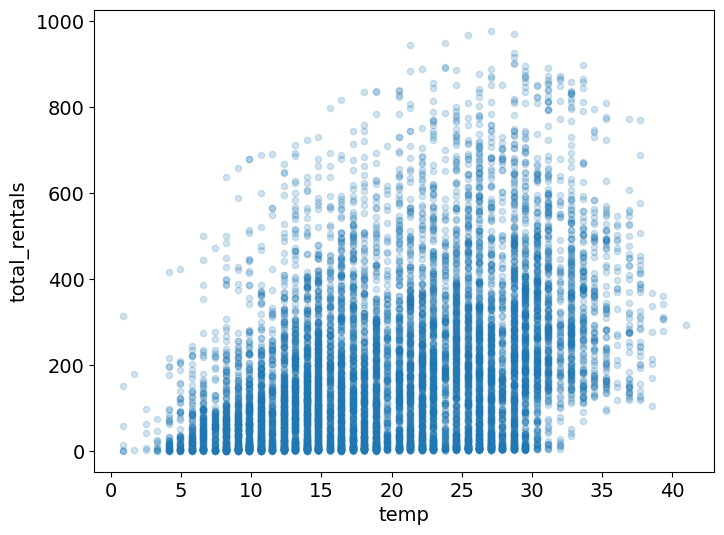

In [6]:
# Pandas scatterplot
bikes.plot(kind='scatter', x='temp', y='total_rentals', alpha=0.2)

<a id="linear-regression-basics"></a>
## Linear Regression Basics
---

<a id="form-of-linear-regression"></a>
### Form of Linear Regression

Recall that each model always contains some amount of random irreducible error $\epsilon$. So, given a prediction $\hat{y}$, the actual $y = \hat{y} + \epsilon$. Below, we will assume $y$ is exactly linear.

- We are often taught the formula for a line is: $y = mx + b$.
- Note this can alternatively be written: $y = \alpha + \beta X$.

---

Here, we will generalize this to $n$ independent variables as follows:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response.
- $\beta_0$ is the intercept.
- $\beta_1$ is the coefficient for $x_1$ (the first feature).
- $\beta_n$ is the coefficient for $x_n$ (the nth feature).
- $\epsilon$ is the _error_ term

A practical example of this applied to our data might be:

$total\_rides = 20 + -2 \cdot temp + -3 \cdot windspeed\ +\ ...\ +\ 0.1 \cdot registered$

This equation is still called **linear** because the highest degree of the independent variables (e.g. $x_i$) is 1. Note that because the $\beta$ values are constants, they will not be independent variables in the final model, as seen above.

---

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are trying to find the line (mathematically) that minimizes the **sum of squared residuals** (or "sum of squared errors").
- Once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](https://alik-courses.web.app/intro-to-ai/linear_regression/images/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

# Finding the mimimal error

<img src="https://alik-courses.web.app/intro-to-ai/linear_regression/images/gradient.gif" width="700" height="350" align="center"/>

<a id="overview-of-supervised-learning"></a>
## Overview of Supervised Learning
---

![Supervised learning diagram](https://alik-courses.web.app/intro-to-ai/linear_regression/images/supervised_learning.png)

<a id="requirements-for-working-with-data-in-scikit-learn"></a>
### Requirements for Working With Data in scikit-learn

1. Features and response should be separate objects.
2. Features and response should be entirely numeric.
3. Features and response should be NumPy arrays (or easily converted to NumPy arrays).
4. Features and response should have specific shapes (outlined below).

<a id="building-a-linear-regression-model-in-sklearn"></a>
## Building a Linear Regression Model in sklearn

#### Create a feature matrix called X that holds a `DataFrame` with only the temp variable and a `Series` called y that has the "total_rentals" column.

In [74]:
# Create X and y.
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total_rentals

In [75]:
X.head()

,temp
datetime,
2011-01-01 00:00:00,9.84
2011-01-01 01:00:00,9.02
2011-01-01 02:00:00,9.02
2011-01-01 03:00:00,9.84
2011-01-01 04:00:00,9.84


In [76]:
y.head()

datetime
2011-01-01 00:00:00    16
2011-01-01 01:00:00    40
2011-01-01 02:00:00    32
2011-01-01 03:00:00    13
2011-01-01 04:00:00     1
Name: total_rentals, dtype: int64

In [77]:
# Check X's type.
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [78]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [79]:
# Check X's shape (n = number of observations, p = number of features).
print((X.shape))

(10886, 1)


In [80]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(10886,)


-----
<a id="scikit-learns--step-modeling-pattern"></a>
# scikit-learn's Four-Step Modeling Pattern

**Step 1:** Import the class you plan to use.

In [16]:
from sklearn.linear_model import LinearRegression

**Step 2:** "Instantiate" the "estimator."

- "Estimator" is scikit-learn's term for "model."
- "Instantiate" means "make an instance of."

In [83]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model._base.LinearRegression

- Created an object that "knows" how to do linear regression, and is just waiting for data.
- Name of the object does not matter.
- All parameters not specified are set to their defaults.
- Can specify tuning parameters (aka "hyperparameters") during this step. 

To view the possible parameters, either use the `help` built-in function or evaluate the newly instantiated model, as follows:

In [84]:
# help(lr)
lr

LinearRegression()

**Step 3:** Fit the model with data (aka "model training").

- Model is "learning" the relationship between X and y in our "training data."
- Process through which learning occurs varies by model.
- Occurs in-place.

In [85]:
lr.fit(X, y)

LinearRegression()

- Once a model has been fit with data, it's called a "fitted model."

**Step 4:** Predict the response for a new observation.

- New observations are called "out-of-sample" data.
- Uses the information it learned during the model training process.

In [86]:
lr.predict([[4]])

C:\Users\ali_k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([42.72837489])

In [87]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0,15,20,4]).reshape(4,-1))

C:\Users\ali_k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([  6.04621296, 143.60432018, 189.45702259,  42.72837489])

In [ ]:
np.array([0,15,20,4]).reshape(4,-1)

array([[ 0],
       [15],
       [20],
       [ 4]])

Let's ask the model to make two predictions, one when the `temp` is 0 and another when the `temp` is 10. To do this, our feature matrix is always a 2-D array where each row is a list of features. Since we only have a single feature, the temperature, each row will contain only a single value.

In [24]:
X_new = [[0], [10]]
lr.predict(X_new)

C:\Users\ali_k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([ 6.04621296, 97.75161777])

- Returns a NumPy array, and we keep track of what the numbers "mean."
- Can predict for multiple observations at once.

What we just predicted using our model is, "If the temperature is 0 degrees, the total number of bike rentals will be ~6.046, and if the temperature is 10 degrees the total number of bike rentals will ~97.751."

<a id="build-a-linear-regression-model"></a>
## Build a Linear Regression Model
---

Let's specifically make a linear regression model and look at the intercept and coefficients.

#### Instantiate and fit a `LinearRegression` model on X and y from the `linear_model` section of scikit-learn.

In [26]:
# Import, instantiate, fit.
# We do not need to import the LinearRegression class again because 
# we have already done it in this notebook, but for the sake of comleteness
# it is added here too.
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression()

In [27]:
# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

6.046212959616469
[9.17054048]


Interpreting the intercept ($\beta_0$):

- It is the value of $y$ when all independent variables are 0.
- Here, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the "temp" coefficient ($\beta_1$):

- **Interpretation:** An increase of 1 degree Celcius is _associated with_ increasing the number of total rentals by $\beta_1$.
- Here, a temperature increase of 1 degree Celsius is _associated with_ a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in total rentals.
- $\beta_1$ would be **zero** if temperature is not associated with total rentals.

<a id="using-the-model-for-prediction"></a>
## Using the Model for Prediction

---

While plenty of insight can be found in reading coefficients, the most common uses of data science focus on prediction. In scikit-learn we can make predictions from a fitted model using `.predict()`, but we will also go through the calculation by hand to understand it.

#### How many bike rentals would we predict if the temperature was 25 degrees Celsius?

#### Explore the intercept and coefficients of the linear model.

You can search for "sklearn linear regression" and explore the attributes section of the documentation to learn how to do this.

In [28]:
# Manually calculate the prediction.
#temp 15
6.04621295961681 + 9.17054048 * 25

235.3097249596168

In [29]:
# Use the predict method.
lr.predict([[25]])

C:\Users\ali_k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([235.309725])

<a id="does-the-scale-of-the-features-matter"></a>
### Does the Scale of the Features Matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [30]:
# Create a new column for Fahrenheit temperature.
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


#### Rebuild the `LinearRegression` from above using the `temp_F` features instead.

In [31]:
# Create X and y.
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

-156.98561782129275
[5.09474471]


#### Convert 25 degrees Celsius to Fahrenheit.

In [32]:
25 * 1.8 + 32

77.0

#### Predict rentals for 77 degrees Fahrenheit.

In [33]:
linreg.predict([[77]])

C:\Users\ali_k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([235.309725])

**Conclusion:** The scale of the features is irrelevant for linear regression models when using `Ordinary Least Squares` method which is the case for sklearn LinearRegression. When changing the scale, we simply change our interpretation of the coefficients.  
If gradient descent is used instead, making the scale of features roughly the same can help the gradient descent to converge better.

In [34]:
# Remove the temp_F column.
bikes.drop('temp_F', axis=1, inplace=True)

<a id="work-with-multiple-features"></a>
## Work With Multiple Features
---

We've demonstrated simple linear regression with one feature to gain an intuition, but the benefit of modeling is the ability to reason about hundreds of features at once. There is no limit to the number of features you can use. However, often a small set of features accounts for most of the variance (assuming there is a linear relationship at all). We will start by using four features.

## Split train / validation sets
In order to propertly be able to train and compare models, we need to separate the test and validation sets.

In [88]:
bikes.shape

(10886, 11)

In [89]:
from sklearn.model_selection import train_test_split

In [96]:
bikes_train, bikes_val = train_test_split(bikes, test_size=0.3, random_state=123)

In [97]:
print(f'train set shape: {bikes_train.shape}')
print(f'validation set shape: {bikes_val.shape}')

train set shape: (7620, 11)
validation set shape: (3266, 11)


<a id="visualizing-the-data-part-"></a>
### Visualizing the Data (Part 2)

#### Explore more features

In [98]:
# Create feature column variables
feature_cols = ['temp', 'season', 'weather', 'humidity']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the y_vars argument to only show relationships with the `total_rentals` variable

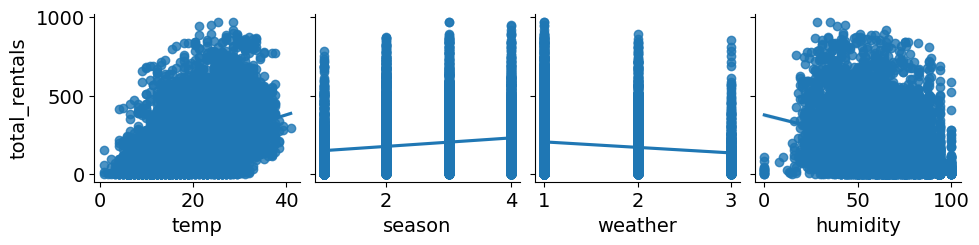

In [99]:
# multiple scatterplots in Seaborn
sns.pairplot(bikes_train, x_vars=feature_cols, y_vars='total_rentals', kind='reg')

#### Recreate the same functionality using Pandas.

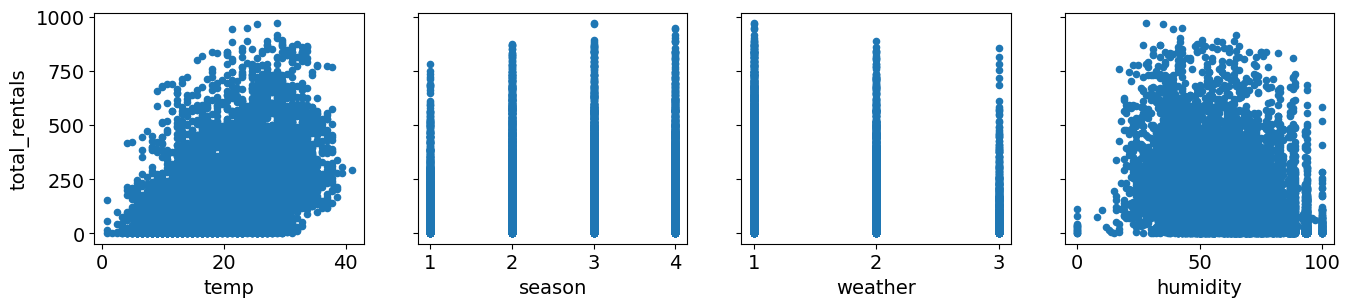

In [100]:
# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes_train.plot(kind='scatter', x=feature, y='total_rentals', ax=axs[index], figsize=(16, 3))

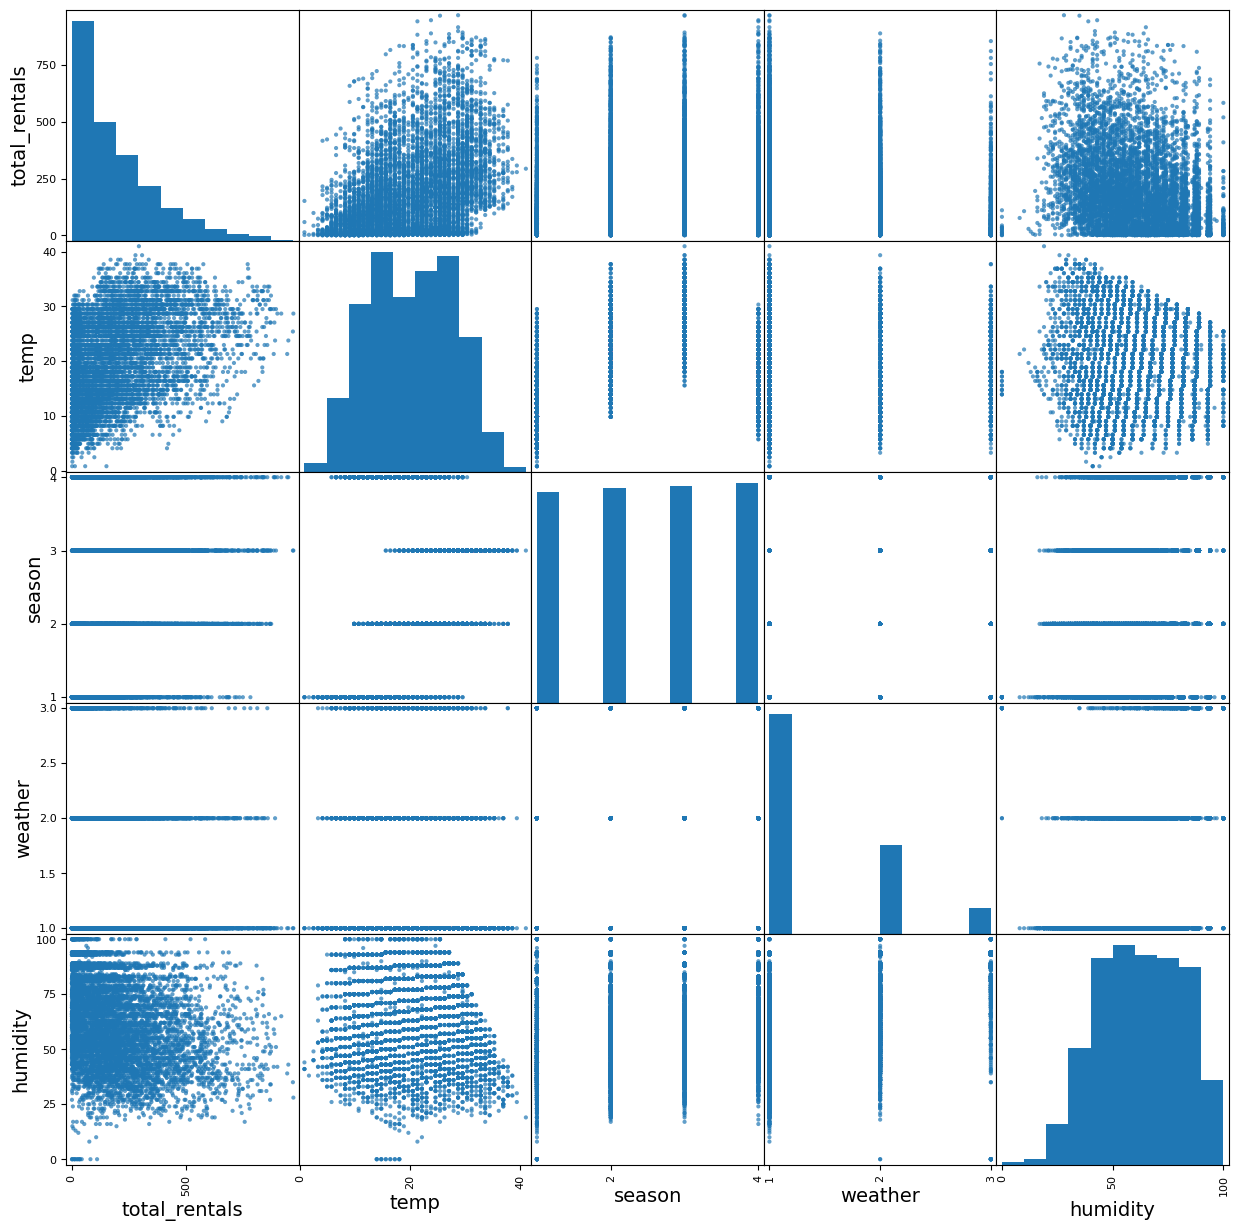

In [101]:
# alternative way in Pandas (might take a while)
# scatter_matrix does a pairplot of *every* column

grr = pd.plotting.scatter_matrix(bikes_train[['total_rentals'] + feature_cols], figsize=(15, 15), alpha=0.7)

#### Explore the season variable using a box plot.

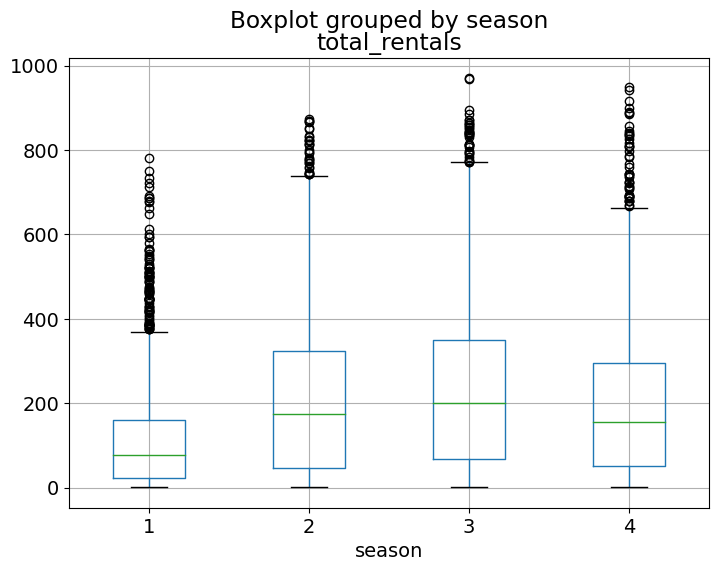

In [102]:
# Box plot of rentals, grouped by season
bikes_train.boxplot(column='total_rentals', by='season');

#### Look at rentals over time.

<AxesSubplot: xlabel='datetime'>

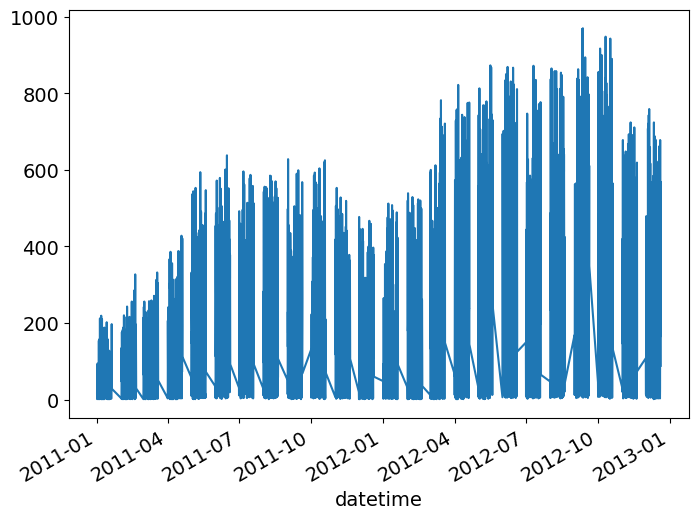

In [103]:
# Line plot of rentals
bikes_train.total_rentals.plot()

#### What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.

#### Look at the correlation matrix for the bikes `DataFrame`.

In [104]:
# Correlation matrix (ranges from 1 to -1)
bikes_train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals
season,1.000000,0.029560,-0.003760,0.012162,0.258468,0.265023,0.191525,-0.136857,0.092239,0.167774,0.165607
holiday,0.029560,1.000000,-0.247005,-0.008407,0.006489,-0.000031,-0.004815,0.009542,0.050867,-0.020929,-0.003454
workingday,-0.003760,-0.247005,1.000000,0.032237,0.038705,0.033672,-0.011534,0.010703,-0.315516,0.125692,0.017983
weather,0.012162,-0.008407,0.032237,1.000000,-0.060263,-0.059365,0.396055,0.008246,-0.129237,-0.103626,-0.122220
temp,0.258468,0.006489,0.038705,-0.060263,1.000000,0.985408,-0.065815,-0.033341,0.473128,0.325418,0.402365
atemp,0.265023,-0.000031,0.033672,-0.059365,0.985408,1.000000,-0.043740,-0.072681,0.468166,0.322200,0.398309
humidity,0.191525,-0.004815,-0.011534,0.396055,-0.065815,-0.043740,1.000000,-0.322403,-0.346652,-0.263366,-0.315640
windspeed,-0.136857,0.009542,0.010703,0.008246,-0.033341,-0.072681,-0.322403,1.000000,0.081296,0.090171,0.097755
non_registered_users,0.092239,0.050867,-0.315516,-0.129237,0.473128,0.468166,-0.346652,0.081296,1.000000,0.490304,0.685439
registered,0.167774,-0.020929,0.125692,-0.103626,0.325418,0.322200,-0.263366,0.090171,0.490304,1.000000,0.970676


#### Use a heat map to make it easier to read the correlation matrix.

<AxesSubplot: >

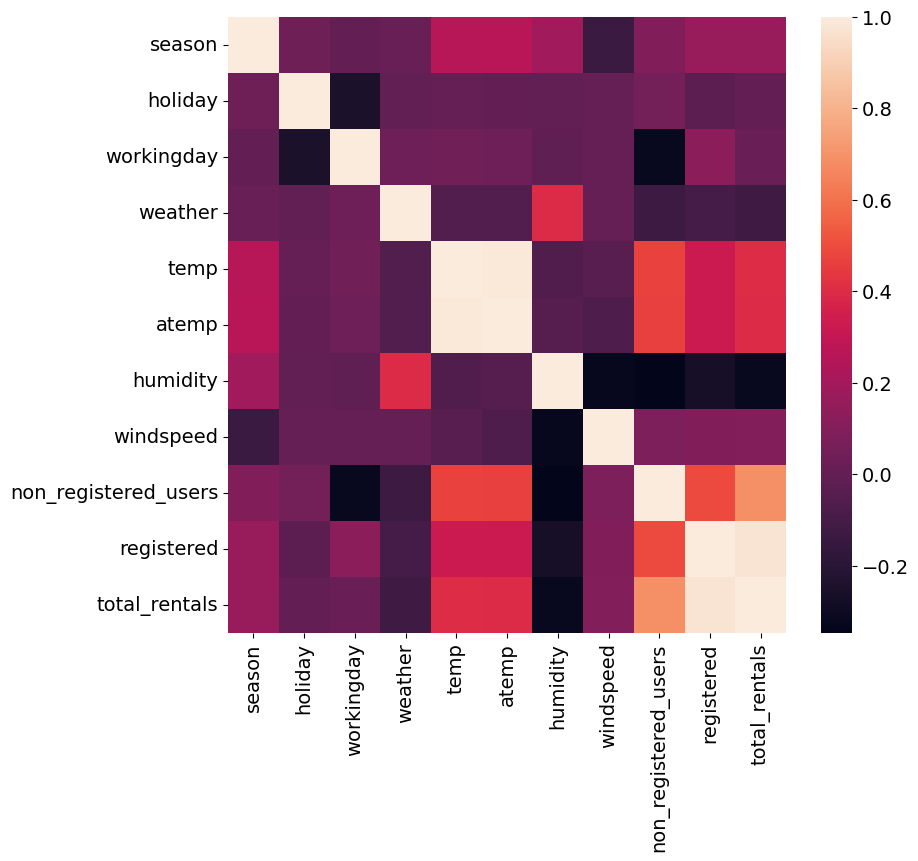

In [105]:
# Visualize correlation matrix in Seaborn using a heat map.
plt.figure(figsize = (9,8))
sns.heatmap(bikes_train.corr())

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of one another, but all of them should help explain the y variable.

We'll work with bikeshare data to showcase what this means and to explain a concept called multicollinearity.

#### Create another `LinearRegression` instance and train it using temp, season, weather, and humidity.

In [106]:
# Create a list of features.
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [107]:
# Create X and y.
X = bikes_train[feature_cols]
y = bikes_train.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

154.787195104063
[ 8.07586083 22.5801402   7.99319996 -3.13106488]


#### Display the linear regression coefficient along with the feature names.

In [108]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('temp', 8.075860833259526),
 ('season', 22.58014020497805),
 ('weather', 7.993199958179714),
 ('humidity', -3.1310648808249377)]

Interpreting the coefficients:

- Holding all other features fixed, a 1-unit increase in temperature is associated with a rental increase of 7.86 bikes.
- Holding all other features fixed, a 1-unit increase in season is associated with a rental increase of 22.5 bikes.
- Holding all other features fixed, a 1-unit increase in weather is associated with a rental increase of 6.67 bikes.
- Holding all other features fixed, a 1-unit increase in humidity is associated with a rental decrease of 3.12 bikes.

Does anything look incorrect and does not reflect reality?

# Try new feature combinations and anlyze the coefficients 
<img src="https://alik-courses.web.app/intro-to-ai/linear_regression/images/hands_on.jpg" width="100" height="100" align="right"/>

In [109]:
# type your answer here 
#             ['temp', 'season', 'weather', 'humidity']
linreg.predict([[23,      2,         3,          5]])


C:\Users\ali_k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([394.01655015])

<a id="what-is-multicollinearity"></a>
## What Is Multicollinearity?
---

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.

In [110]:
bikes_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals
datetime,,,,,,,,,,,
2011-09-19 15:00:00,3,0,1,2,24.60,30.305,60,15.0013,44,143,187
2012-09-09 07:00:00,3,0,0,1,22.14,25.760,73,11.0014,20,50,70
2012-03-04 07:00:00,1,0,0,2,12.30,13.635,52,19.9995,2,21,23
2012-02-09 09:00:00,1,0,1,1,8.20,9.850,59,15.0013,9,229,238
2012-03-17 07:00:00,1,0,0,2,16.40,20.455,100,8.9981,29,57,86


#### With the bikeshare data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

                          temp     atemp  non_registered_users
temp                  1.000000  0.985408              0.473128
atemp                 0.985408  1.000000              0.468166
non_registered_users  0.473128  0.468166              1.000000


<AxesSubplot: >

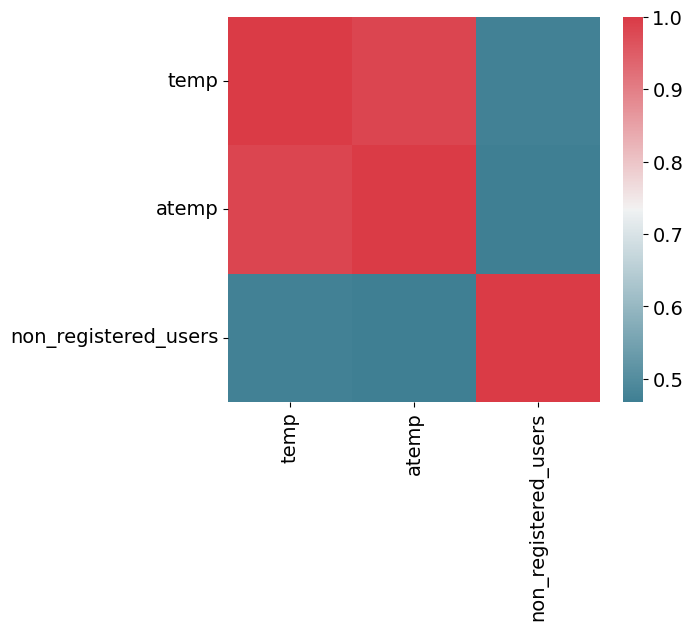

In [111]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes_train[['temp', 'atemp', 'non_registered_users']].corr()
print(correlations)
plt.figure(figsize = (6,5))
sns.heatmap(correlations, cmap=cmap)

#### Create a linear model that predicts `total_rentals` using `temp` and `atemp`.

In [112]:
# Create a list of features.
feature_cols = ['temp', 'atemp']

In [115]:
# Create X and y.
X = bikes_train[feature_cols]
y = bikes_train.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

-0.5226645589349914
[7.94289919 1.34214395]


#### Go back and remove either `temp` or `atemp` from the feature list. How do the coefficients change? 

In [ ]:
# A:

<a id="how-to-select-a-model"></a>
## How to Select a Model
---

We can make linear models now, but how do we select the best model to use for our applications? We will offer a general procedure and a simple metric that works well in many cases. That said, it's important to keep the business context in mind and know that there are alternative metrics that can work better.

<a id="feature-selection"></a>
### Feature Selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use p-values or R-squared for feature selection?

- Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- If all of the assumptions of a linear model are met, p-values suggest a coefficient that differs from zero at a level of statistical significance. This does not mean that
    1. the feature _causes_ the response
    2. the feature strongly _predicts_ the response. 
- Adding features to your model that are unrelated to the response will always increase the R-squared value, and adjusted R-squared does not sufficiently account for this (although, AIC and BIC do).
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to directly estimate how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a machine learning methodology.
- This course focuses on general purpose approaches that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

Evaluation metrics for classification problems, such as accuracy, are not useful for regression problems. We need evaluation metrics designed for comparing continuous values.

Here are three common evaluation metrics for regression problems:

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [116]:
# Example true and predicted response values
true_y = [10, 7, 5, 5]
pred_y = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and NumPy.

In [117]:
# Calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true_y, pred_y))
print('MSE:', metrics.mean_squared_error(true_y, pred_y))
print('RMSE:', metrics.mean_squared_error(true_y, pred_y, squared=False))

MAE: 2.0
MSE: 7.5
RMSE: 2.7386127875258306


Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world. Also, MSE is continuous and differentiable, making it easier to use than MAE for optimization.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punishes larger errors:

In [119]:
# Same true values as above
true_y = [10, 7, 5, 5]

# New set of predicted values
pred_y = [10, 7, 5, 13]

# MAE is the same as before.
print('MAE:', metrics.mean_absolute_error(true_y, pred_y))

# MSE and RMSE are larger than before.
print('MSE:', metrics.mean_squared_error(true_y, pred_y))
print('RMSE:', metrics.mean_squared_error(true_y, pred_y, squared=False))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

<img src="https://alik-courses.web.app/intro-to-ai/linear_regression/images/train_test_split.svg" width="500" height="500" align="center"/>

In [120]:
# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df_train, df_val, feature_cols):
    X_train = df_train[feature_cols]
    y_train = df_train.total_rentals
    X_val = df_val[feature_cols]
    y_val = df_val.total_rentals
    print('-----')
    print('size of train data : ', X_train.shape)
    print('size of test data : ', X_val.shape)
    
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_val)
    return metrics.mean_squared_error(y_val, y_pred, squared=False)

In [121]:
# Compare different sets of features.
print(train_test_rmse(bikes_train, bikes_val, ['temp', 'season', 'weather', 'humidity']))
print(train_test_rmse(bikes_train, bikes_val, ['temp', 'season', 'weather']))
print(train_test_rmse(bikes_train, bikes_val, ['temp', 'season', 'humidity']))

-----
size of train data :  (7620, 4)
size of test data :  (3266, 4)
156.50681446308081
-----
size of train data :  (7620, 3)
size of test data :  (3266, 3)
165.1737396072974
-----
size of train data :  (7620, 3)
size of test data :  (3266, 3)
156.4977802739207


In [122]:
# Using these as features is not allowed!
print(train_test_rmse(bikes_train, bikes_val, ['non_registered_users', 'registered']))

-----
size of train data :  (7620, 2)
size of test data :  (3266, 2)
2.1191481720965422e-13


<a id="feature-engineering-to-improve-performance"></a>
## Feature Engineering to Improve Performance

<img src="https://alik-courses.web.app/intro-to-ai/linear_regression/images/feature engineering.jpg" width="200" height="200" style="float:right; margin:12ps"/>

---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.


<a id="handling-categorical-features"></a>
### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** Transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** Use dummy encoding (one hot encoding). Here, each possible category would become a separate feature.

What are the categorical features in our data set?

- **Ordered categories:** `weather` (already encoded with sensible numeric values)
- **Unordered categories:** `season` (needs dummy encoding), `holiday` (already dummy encoded), `workingday` (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.

In [123]:
bikes_train.head()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals
datetime,,,,,,,,,,,
2011-09-19 15:00:00,3,0,1,2,24.60,30.305,60,15.0013,44,143,187
2012-09-09 07:00:00,3,0,0,1,22.14,25.760,73,11.0014,20,50,70
2012-03-04 07:00:00,1,0,0,2,12.30,13.635,52,19.9995,2,21,23
2012-02-09 09:00:00,1,0,1,1,8.20,9.850,59,15.0013,9,229,238
2012-03-17 07:00:00,1,0,0,2,16.40,20.455,100,8.9981,29,57,86


#### Create dummy variables using `get_dummies` from Pandas.

In [124]:
season_dummies_train = pd.get_dummies(bikes_train.season, prefix='season')
season_dummies_train

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-19 15:00:00,0,0,1,0
2012-09-09 07:00:00,0,0,1,0
2012-03-04 07:00:00,1,0,0,0
2012-02-09 09:00:00,1,0,0,0
2012-03-17 07:00:00,1,0,0,0
...,...,...,...,...
2012-10-12 02:00:00,0,0,0,1
2012-06-03 20:00:00,0,1,0,0
2011-12-11 12:00:00,0,0,0,1


#### Inspect the `DataFrame` of `dummies`.

In [125]:
# Print five random rows.
season_dummies_train.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2012-09-18 07:00:00,0,0,1,0
2011-12-03 16:00:00,0,0,0,1
2012-11-12 11:00:00,0,0,0,1
2011-09-04 04:00:00,0,0,1,0
2012-03-18 18:00:00,1,0,0,0


#### We now need to concatenate the two `DataFrames` together.

In [130]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies_train = pd.concat([bikes_train, season_dummies_train], axis=1)

bikes_dummies_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,
2011-09-19 15:00:00,3,0,1,2,24.60,30.305,60,15.0013,44,143,187,0,0,1,0
2012-09-09 07:00:00,3,0,0,1,22.14,25.760,73,11.0014,20,50,70,0,0,1,0
2012-03-04 07:00:00,1,0,0,2,12.30,13.635,52,19.9995,2,21,23,1,0,0,0
2012-02-09 09:00:00,1,0,1,1,8.20,9.850,59,15.0013,9,229,238,1,0,0,0
2012-03-17 07:00:00,1,0,0,2,16.40,20.455,100,8.9981,29,57,86,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-12 02:00:00,4,0,1,1,16.40,20.455,66,6.0032,0,16,16,0,0,0,1
2012-06-03 20:00:00,2,0,0,1,27.06,31.060,39,12.9980,84,230,314,0,1,0,0
2011-12-11 12:00:00,4,0,0,1,10.66,15.150,35,0.0000,42,246,288,0,0,0,1


We need to do the exact pre-processing for validation/test set as well.

In [129]:
season_dummies_val = pd.get_dummies(bikes_val.season, prefix='season')
bikes_dummies_val = pd.concat([bikes_val, season_dummies_val], axis=1)
bikes_dummies_val


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,non_registered_users,registered,total_rentals,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,
2012-03-07 21:00:00,1,0,1,1,18.04,21.970,62,16.9979,11,177,188,1,0,0,0
2012-04-12 03:00:00,2,0,1,1,13.12,15.150,61,16.9979,2,3,5,0,1,0,0
2011-02-06 10:00:00,1,0,0,1,12.30,14.395,52,16.9979,15,74,89,1,0,0,0
2011-12-05 23:00:00,4,0,1,2,18.86,22.725,88,8.9981,8,54,62,0,0,0,1
2011-08-08 14:00:00,3,0,1,1,33.62,37.120,43,19.9995,41,109,150,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-09-06 12:00:00,3,0,1,3,22.14,25.760,83,26.0027,16,51,67,0,0,1,0
2011-01-02 00:00:00,1,0,0,2,18.86,22.725,88,19.9995,4,13,17,1,0,0,0
2012-10-06 11:00:00,4,0,0,1,26.24,30.305,65,16.9979,258,389,647,0,0,0,1


#### Rerun the linear regression with dummy variables included.

In [132]:
# Include dummy variables for season in the model.
feature_cols = ['temp','season_1', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies_train[feature_cols]
y = bikes_dummies_train.total_rentals

linreg = LinearRegression()
linreg.fit(X, y)

list(zip(linreg.feature_names_in_, linreg.coef_))

[('temp', 11.578831734680158),
 ('season_1', -3.037192886705272),
 ('season_2', -7.9903001755973975),
 ('season_3', -49.60975422379227),
 ('season_4', 60.637247286094805),
 ('humidity', -2.812024034175567)]

How do we interpret the season coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have the dummy that is your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [133]:
# Compare original season variable with dummy variables.
print(train_test_rmse(bikes_dummies_train, bikes_dummies_val, ['temp', 'season', 'humidity']))
print(train_test_rmse(bikes_dummies_train, bikes_dummies_val, ['temp','season_1', 'season_2', 'season_3', 'season_4', 'humidity']))

-----
size of train data :  (7620, 3)
size of test data :  (3266, 3)
156.4977802739207
-----
size of train data :  (7620, 6)
size of test data :  (3266, 6)
155.22988726432473


<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.

<img src="https://alik-courses.web.app/intro-to-ai/linear_regression/images/hands_on.jpg" width="100" height="100" style="float:right"/>

# Exercise

## Sacramento Real Estate Data

### Goal: Perdict the Price of a house!

- Just use numerical features for the prediction (beds, bath, sq_ft, latitude, longtitude)
 
#### How? 
- Expolore the dataset
- Clean it 
- Do Feature Engineering 
- Create nesseccary encodings 
- Build a regression model 
- Test it

In [ ]:
sac_csv = 'https://alik-courses.web.app/intro-to-ai/linear_regression/data/sacramento_real_estate_transactions.csv'
sac=pd.read_csv(sac_csv)
sac.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768
